In [47]:
import pandas as pd
import numpy as np
import subprocess
from sklearn.manifold import TSNE
from Bio.Cluster import kcluster
import matplotlib.pyplot as plt
from collections import Counter
import glob
import os
import shutil

## Prepare for analysis

In [48]:
input="hCD123s"
#input_dataframe=pd.read_csv(f"output/{input}/opt_binders/all.csv")
input_dataframe=pd.read_csv(f"output/{input}/partial_diff/diffusions/af2_best.csv")
input_dataframe

,mpnn,seq,plddt,i_ptm,i_pae,rmsd,model_path,input_pdb
0,1.181182,WRGAENLTCWIHDVDFLSCSWEVGPGAPPDVQYDLYLNVKNRRQQY...,0.828265,0.557344,9.876548,2.631013,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
1,1.155667,WRGAENLTCWIHDVDFLSCSWKVGPGAPPDVQYDLYLNVDNRRQQY...,0.727700,0.719361,11.888236,2.908558,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
2,1.115519,WRGAENLTCWIHDVDFLSCSWDVGPGAPPDVQYDLYLNVDNRRQQY...,0.843280,0.436356,13.091659,1.504061,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
3,1.121437,WRGAENLTCWIHDVDFLSCSWDVGPGAPPDVQYDLYLNVDNRRQQY...,0.865630,0.440304,12.403959,2.630444,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
4,1.113312,WRGAENLTCWIHDVDFLSCSWDVGPGAPPDVQYDLYLNVENRRQQY...,0.764437,0.676324,9.939987,2.849991,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
...,...,...,...,...,...,...,...,...
11542,1.260798,WRGAENLTCWIHDVDFLSCSWDVGPGAPPDVQYDLYLNVENRRQQY...,0.764334,0.775261,6.876171,2.596099,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
11543,1.268568,WRGAENLTCWIHDVDFLSCSWDVGPGAPPDVQYDLYLNVDNRRQQY...,0.761885,0.797544,6.636479,1.935361,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
11544,1.266398,WRGAENLTCWIHDVDFLSCSWEVGPGAPPDVQYDLYLNVENRRQQY...,0.764430,0.783716,6.601668,1.459038,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...
11545,1.240270,WRGAENLTCWIHDVDFLSCSWDVGPGAPPDVQYDLYLNVDNRRQQY...,0.719957,0.751014,7.938496,1.902035,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...


In [49]:
def add_diff_column(df):
    df["diff"] = df["model_path"].apply(lambda x: x.split("/")[-1][:4])
    return df

## Filter dataframe

In [56]:
#filtered = input_dataframe[(input_dataframe["rmsd"]<1)&(input_dataframe["plddt"]>0.85)&input_dataframe["i_pae"]<6]
filtered =input_dataframe[(input_dataframe["plddt"]>0.92)&(input_dataframe["i_pae"]<5)&(input_dataframe["rmsd"]<2)]

filtered = filtered.sort_values(by='plddt', ascending=False).drop_duplicates("model_path").reset_index()#.head(9900)
filtered = add_diff_column(filtered)
filtered

,index,mpnn,seq,plddt,i_ptm,i_pae,rmsd,model_path,input_pdb,diff
0,9499,1.103855,WRGAENLTCWIHDVDFLSCSWSVGPGAPPDVQYDLYLNVDNRRQQY...,0.961992,0.863533,3.762181,1.956804,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,U5BC
1,9493,1.129925,WRGAENLTCWIHDVDFLSCSWRVGPGAPPDVQYDLYLNVDNRRQQY...,0.961944,0.874957,3.668679,1.960442,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,U5BC
2,3802,1.042825,WRGAENLTCWIHDVDFLSCSWDVGPGAPPDVQYDLYLNVDNRRQQY...,0.960311,0.810453,4.791048,1.648200,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,DLJT
3,3805,1.038956,WRGAENLTCWIHDVDFLSCSWKVGPGAPPDVQYDLYLNVDNRRQQY...,0.959586,0.805869,4.878899,1.666267,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,DLJT
4,9476,1.136734,WRGAENLTCWIHDVDFLSCSWSVGPGAPPDVQYDLYLNVDNRRQQY...,0.958637,0.860418,3.828178,1.955868,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,U5BC
...,...,...,...,...,...,...,...,...,...,...
897,2347,1.149390,WRGAENLTCWIHDVDFLSCSWSVGPGAPPDVQYDLYLNVENRRQQY...,0.920115,0.852079,4.775575,1.599076,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,9YIP
898,5413,1.186520,WRGAENLTCWIHDVDFLSCSWSVGPGAPPDVQYDLYLNVENRRQQY...,0.920114,0.827570,4.377161,0.916267,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,GM98
899,1324,1.024968,WRGAENLTCWIHDVDFLSCSWTVGPGAPPDVQYDLYLNVENRRQQY...,0.920102,0.818062,4.614395,1.322314,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,76DG
900,5752,1.118955,WRGAENLTCWIHDVDFLSCSWTVGPGAPPDVQYDLYLNVENRRQQY...,0.920090,0.827993,4.609004,1.450889,output/hCD123s/partial_diff/diffusions/batch_1...,output/hCD123s/partial_diff/diffusions/batch_1...,H89F


In [57]:
# Calculate statistics on scaffolds
scaffold_counts = filtered["diff"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique diffusions:", total_unique_scaffolds)
print("Total diffusion instances:", total_scaffold_instances)
print("\nDiffusion counts:")
print(scaffold_counts)

Total unique diffusions: 28
Total diffusion instances: 902

Diffusion counts:
U5BC    224
H89F    185
GM98    167
9YIP     65
CGAN     60
76DG     40
HL46     30
DZIZ     25
29LP     20
3XBT     20
XDFK     16
PGLG      9
SJ9B      6
DLJT      5
3P4F      5
X4O7      4
JOAP      3
FQG9      3
MLP4      3
NV60      3
AFA1      2
6684      1
5QUE      1
DM55      1
6VYS      1
1GDI      1
9BSR      1
P336      1
Name: diff, dtype: int64


In [58]:
# # filtered=repeat_rows_by_column_value(filtered, "scaffold_name", 1)
# folder=f"/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/{input}/diffusions/test"
# os.makedirs(folder, exist_ok=True)
# for path in filtered["model_path"]:
#     shutil.copy(path, folder)


In [59]:
filtered["seq_split"] = filtered["seq"].apply(lambda x: x.split("/")[-1])
#filtered["seq_split"].to_list()

## Testing cluster sequences

In [60]:
seqs=filtered["seq_split"].to_list()

In [61]:
def length_statistics(input_list):
    length_stats = {}
    
    for item in input_list:
        item_length = len(item)
        length_stats[item_length] = length_stats.get(item_length, 0) + 1
    
    return length_stats

seqs_len=length_statistics(seqs)
print(seqs_len)

{55: 236, 65: 62, 58: 2, 56: 382, 60: 71, 63: 29, 57: 64, 64: 10, 53: 3, 59: 40, 52: 3}


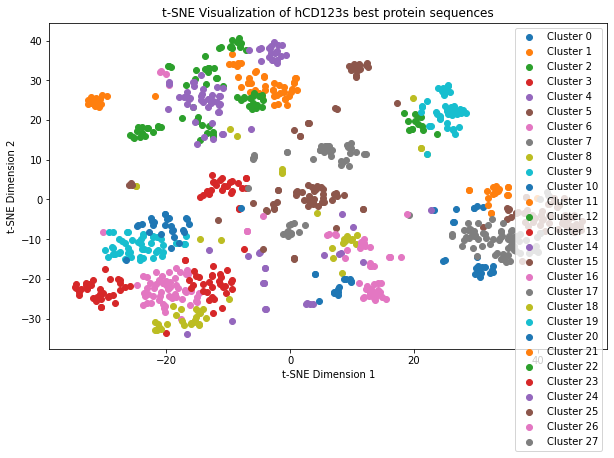

Cluster 0: 23 sequences
Cluster 1: 45 sequences
Cluster 2: 43 sequences
Cluster 3: 27 sequences
Cluster 4: 28 sequences
Cluster 5: 40 sequences
Cluster 6: 57 sequences
Cluster 7: 17 sequences
Cluster 8: 25 sequences
Cluster 9: 48 sequences
Cluster 10: 26 sequences
Cluster 11: 15 sequences
Cluster 12: 24 sequences
Cluster 13: 33 sequences
Cluster 14: 24 sequences
Cluster 15: 35 sequences
Cluster 16: 8 sequences
Cluster 17: 28 sequences
Cluster 18: 25 sequences
Cluster 19: 43 sequences
Cluster 20: 15 sequences
Cluster 21: 18 sequences
Cluster 22: 20 sequences
Cluster 23: 33 sequences
Cluster 24: 35 sequences
Cluster 25: 55 sequences
Cluster 26: 43 sequences
Cluster 27: 69 sequences


,index,mpnn,plddt,i_ptm,i_pae,rmsd
clusterid,,,,,,
0,6109.695652,1.144856,0.934533,0.830419,4.348734,1.325659
1,5658.200000,1.180076,0.926858,0.830183,4.455063,1.383584
2,3695.813953,1.158074,0.930784,0.824215,4.567925,1.284930
3,3760.703704,1.117755,0.929040,0.823759,4.468240,1.346870
4,4534.892857,1.223695,0.937776,0.828202,4.422483,1.420188
5,1605.925000,1.085667,0.928941,0.817835,4.592441,1.402592
6,9642.719298,1.139792,0.934378,0.830192,4.354461,1.382131
7,10018.176471,1.208235,0.929798,0.828625,4.579846,1.475285
8,4827.720000,1.186742,0.931870,0.830878,4.577903,1.422147


In [62]:
num_clusters=28

seqs=filtered["seq_split"].to_list()
#matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in seqs])
max_length = max(len(seq) for seq in seqs)
padded_seqs = [seq.ljust(max_length, 'N') for seq in seqs]
matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in padded_seqs])
clusterid, error, nfound = kcluster(matrix, nclusters=num_clusters)

# Apply t-SNE to the matrix to reduce the dimensionality and visualize the sequences.
tsne = TSNE(n_components=2, random_state=42)
embedded_matrix = tsne.fit_transform(matrix)

# Create a scatter plot of the embedded points and label them with cluster IDs.
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = embedded_matrix[clusterid == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title(f"t-SNE Visualization of {input} best protein sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
#plt.savefig(f"output/{input}/filtered_sequences/tsne_binders.png")
plt.show()


# Print the number of sequences in each cluster.
cluster_counts = Counter(clusterid)
sorted_cluster_counts = dict(sorted(cluster_counts.items()))
for cluster, count in sorted_cluster_counts.items():
    print(f"Cluster {cluster}: {count} sequences")

# Add cluster id to dataframe
filtered["clusterid"]=clusterid
#filtered.to_csv(f"output/{input}/filtered_sequences/2_filtered_binders_clus.csv", index=False)

# Calculate average cluster metrics
average_metrics_by_cluster = filtered.groupby('clusterid').mean()
#average_metrics_by_cluster.to_csv(f"output/{input}/filtered_sequences/2_cluster_average.csv", index=False)
average_metrics_by_cluster

## Prepare metrics command

In [63]:
save_path = f"output/{input}/partial_diff/diffusions/filtered.csv" # Save filtered
metric_path = f"output/{input}/partial_diff/diffusions/metrics.csv" # Save filtered with metrics

# Make filtered dataframe or append new sequences to the old one
if os.path.exists(save_path):
    print("reading existant dataframe...")
    existing_dataframe = pd.read_csv(save_path)
    filtered_new = filtered[~filtered["model_path"].isin(existing_dataframe["model_path"])]
    print(f"existing dataframe of len: {len(existing_dataframe)}, new filtered: {len(filtered_new)}")
    existing_dataframe = pd.concat([existing_dataframe, filtered_new], ignore_index=True)
    print(f"final length: {len(existing_dataframe)}")
    existing_dataframe = existing_dataframe.sort_values(by='plddt', ascending=False)
    #drop duplicates
    existing_dataframe.to_csv(save_path, index=False)
    existing_dataframe.to_csv(metric_path, index=False)

else:
    filtered.to_csv(save_path, index=False)
    filtered.to_csv(metric_path, index=False)
    existing_dataframe=filtered

In [64]:
print(save_path)

output/hCD123s/partial_diff/diffusions/filtered.csv


In [65]:
#test_path="/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/{input}/opt_binders/binders/test"
#os.makedirs(test_path, exist_ok=True)

#for pdb in filtered["model_path"].head(10):
#    !cp $pdb $test_path

## Prepare input files for analysis script

In [66]:
save_directory = f"output/{input}/partial_diff/diffusions/analysis_input"

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

batch_size = 1000

# Split the model_paths into batches
model_paths = existing_dataframe["model_path"]
batches = [model_paths[i:i + batch_size] for i in range(0, len(model_paths), batch_size)]

# Save each batch as a separate TXT file
for i, batch in enumerate(batches):
    save_path = os.path.join(save_directory, "model_paths_" + str(i) + ".txt")
    with open(save_path, "w") as file:
        file.write("\n".join(batch))

## Run analysis script

In [67]:
input_files=glob.glob(f"{save_directory}/*txt")
array_limit=300//len(input_files)
target_chain="A"
binder_chain="B"
xml_file="helper_scripts/metrics_calc.xml"

commands=[]

for input_file in input_files:
    with open(input_file, "r") as file:
        lines = file.readlines()
    array_number = len(lines)-1

    bash_arguments=f"--output=/dev/null --array=0-{array_number}%{array_limit}"
    script_arguments=f"{input_file} {target_chain} {binder_chain} {metric_path} {xml_file}"

    command = f"sbatch {bash_arguments} helper_scripts/binder_analysis.sh {script_arguments}"
    print(command)
    commands.append(command)

print(f"This will run {len(commands)} array scripts")

sbatch --output=/dev/null --array=0-901%300 helper_scripts/binder_analysis.sh output/hCD123s/partial_diff/diffusions/analysis_input/model_paths_0.txt A B output/hCD123s/partial_diff/diffusions/metrics.csv helper_scripts/metrics_calc.xml
This will run 1 array scripts


In [68]:
# Run the array bash script
for command in commands:
    subprocess.run(command, shell=True)

Submitted batch job 512754


In [73]:
!squeue --me

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
512243_[300-532%30       amd binder_a  tsatler PD       0:00      1 (JobArrayTaskLimit)
512754_[300-901%30       amd binder_a  tsatler PD       0:00      1 (JobArrayTaskLimit)
        511840_609       amd binder_a  tsatler  R       1:36      1 compute-4-1
        511840_607       amd binder_a  tsatler  R       1:37      1 compute-0-3
        511840_604       amd binder_a  tsatler  R       1:38      1 compute-4-4
        511840_606       amd binder_a  tsatler  R       1:38      1 compute-4-0
        511840_601       amd binder_a  tsatler  R       1:39      1 compute-4-0
        511840_598       amd binder_a  tsatler  R       1:41      1 compute-4-1
        511840_596       amd binder_a  tsatler  R       1:42      1 compute-4-1
        511840_595       amd binder_a  tsatler  R       1:43      1 compute-0-3
        511840_591       amd binder_a  tsatler  R       1:44      1 compute-4-0
        511840_586 